## compression.ipynb

In [1]:
import sys
sys.path.insert(0,'../cropseg/')

datasetinfo = { "datadir":"/home/ucfaab0/Desktop/su_african_crops_ghana/",
                "metadatadir":"/home/ucfaab0/Desktop/su_african_crops_ghana/metadata/",
                "dataset":"su_african_crops_ghana",
                "groundcollection":"su_african_crops_ghana_labels",
                "s1collection":"su_african_crops_ghana_source_s1",
                "s2collection":"su_african_crops_ghana_source_s2",
                "groundlabels":"su_african_crops_ghana_labels_id.json",
                "groundmetadata":"su_african_crops_ghana_labels.json",
                "s1metadata":"su_african_crops_ghana_source_s1.json",
                "s2metadata":"su_african_crops_ghana_source_s2.json",
                "groundname":"labels.tif",
                "s1imagename":"source.tif",
                "s2imagename":"source.tif",
                "s2maskname":"cloudmask.tif",
                "groundshape":[64,64],
                "s1shape":[64,64],
                "s2shape":[64,64],
                "extension":"tif"
              }
s1bands = [
            {"band":"vv","idx":0},
            {"band":"vh","idx":1},    
          ]  
s2bands = [
            {"band":"blue","wavelength":490,"idx":0},
            {"band":"green","wavelength":560,"idx":1},
            {"band":"red","wavelength":665,"idx":2},
            {"band":"rded1","wavelength":705,"idx":3},
            {"band":"rded2","wavelength":740,"idx":4},
            {"band":"rded3","wavelength":783,"idx":5},
            {"band":"nir","wavelength":842,"idx":6},
            {"band":"rded4","wavelength":865,"idx":7},
            {"band":"swir1","wavelength":1610,"idx":8},
            {"band":"swir2","wavelength":2190,"idx":9}
          ]
s1indices = ["vhvv"]
s2indices = ["ndvi","rdedci","ndmi"]

from mlhubdata import loadjson
groundlabels = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["groundlabels"]}')
groundmetadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["groundmetadata"]}')
s1metadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["s1metadata"]}')
s2metadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["s2metadata"]}')

skiplist = ["001268"]

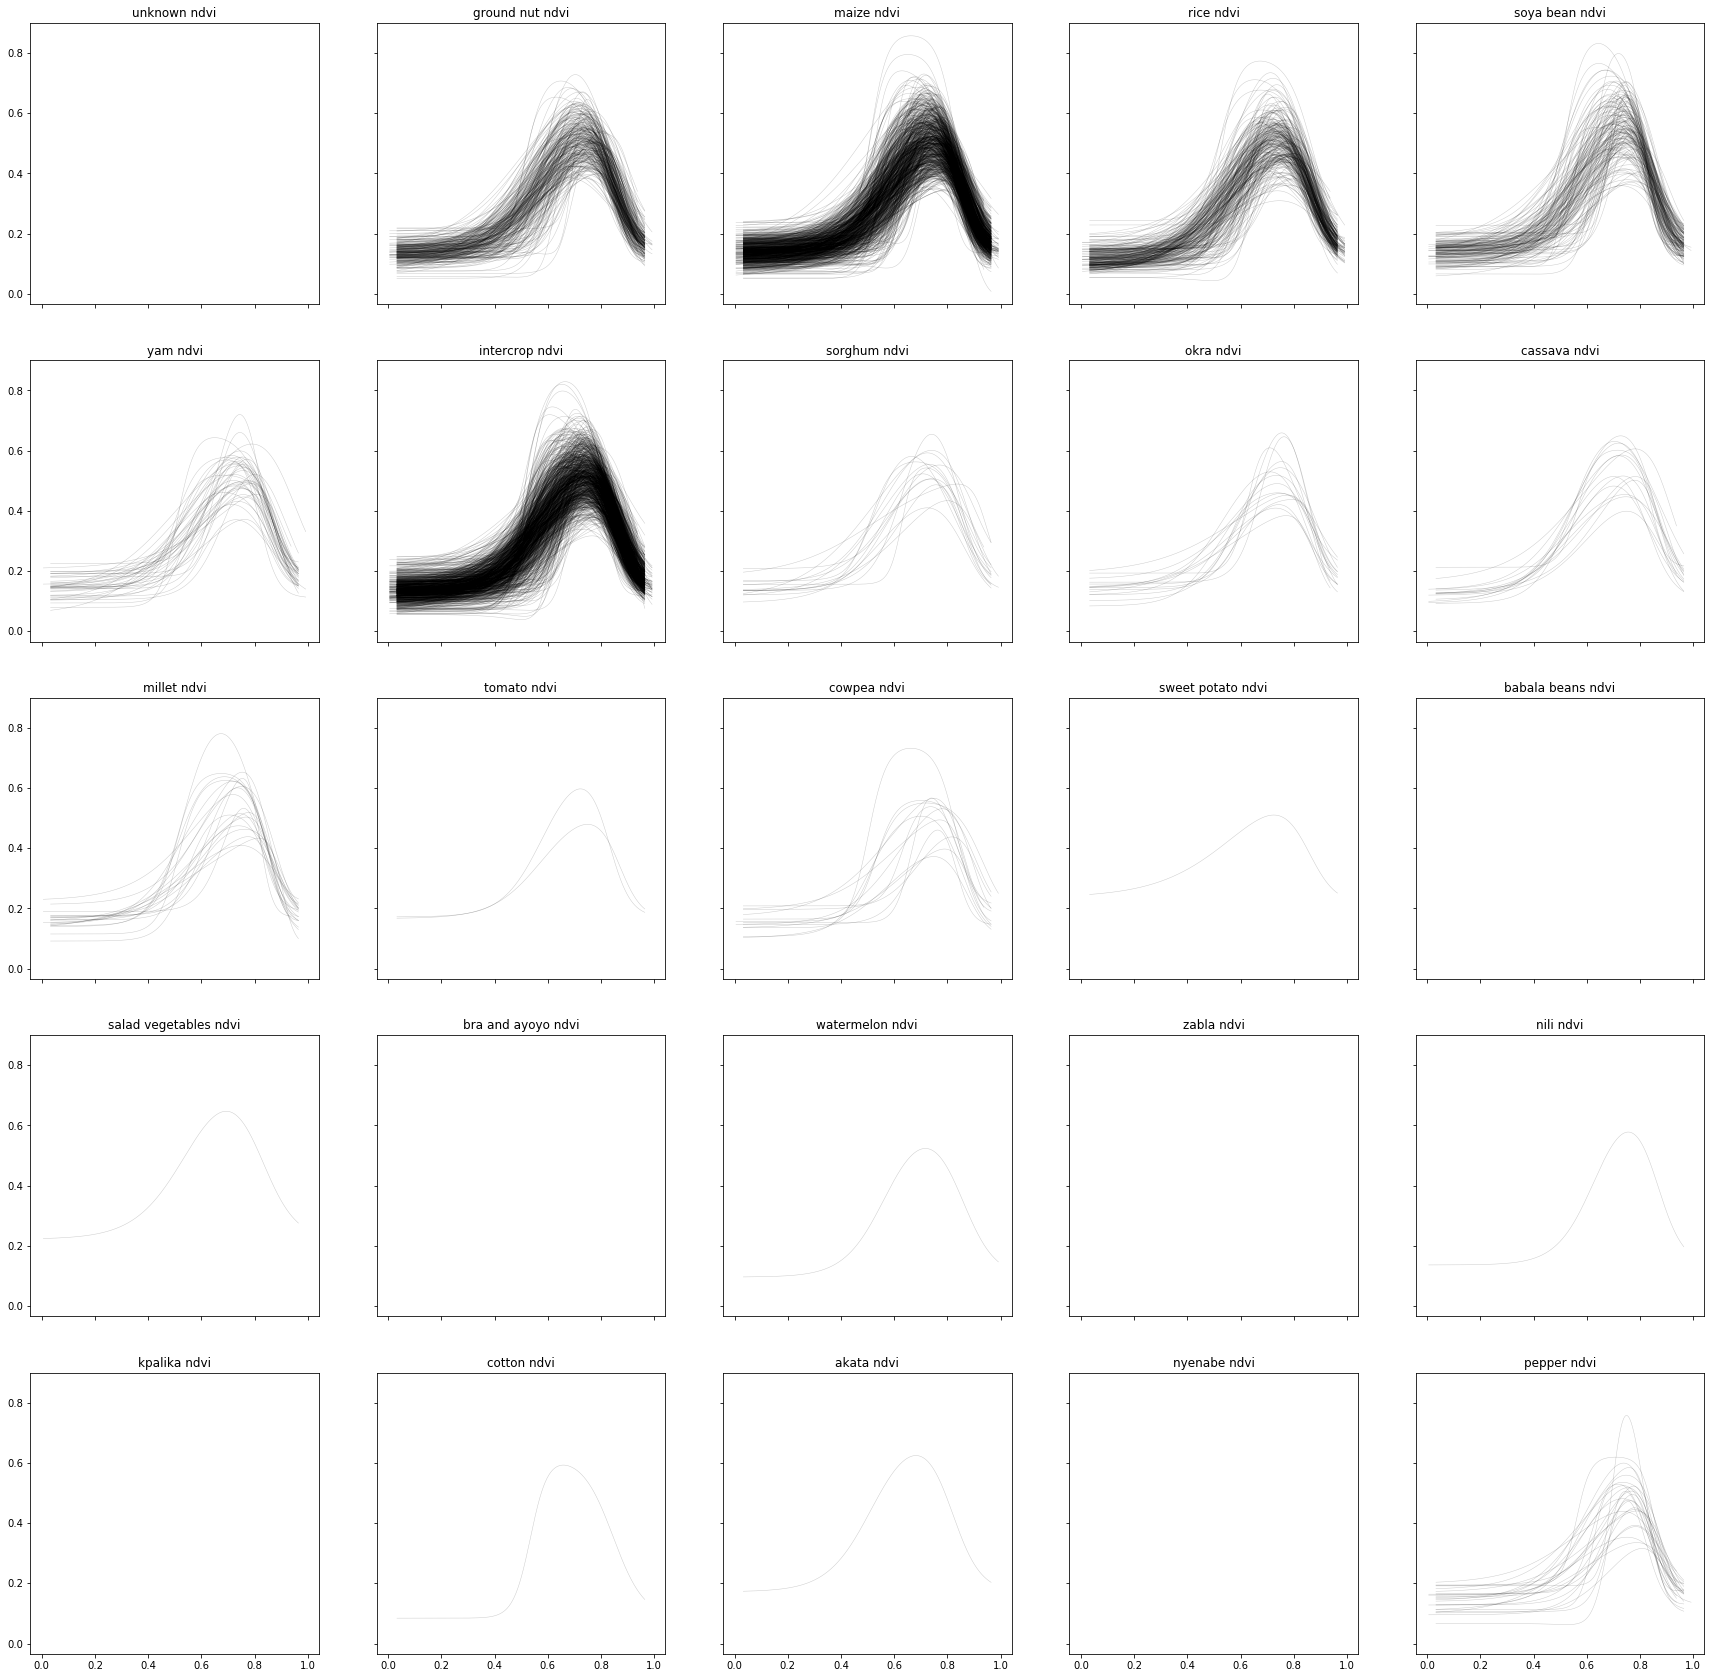

In [3]:
#####
erosioniterations = 2
index = s2indices.index("ndvi")
#####

import numpy
from osgeo import gdal
import scipy.interpolate
import matplotlib.pyplot

from grounddata import erodedfieldmasks
from mlhubdata import get_tileitems_from_collection
from satellitedata import load_satellite_data_as_array
from satellitedata import load_satellite_cloudmasks_as_array
from compression import doublelogistic
from compression import dbllogifunc
from compression import doublelogistic_fittingconditions
from compression import doublelogistic_parameterconditions
from dates import datepositions

datapos = index + len(s2bands)

fig,ax = matplotlib.pyplot.subplots(5,5,figsize=[30,30],sharex="all",sharey="all")
axs = ax.ravel()
for i in range(len(groundmetadata)):
    tileid = groundmetadata[i]["id"].split("_")[len(groundmetadata[i]["id"].split("_"))-1]
    if tileid not in skiplist:
        tilehandle = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["groundcollection"]}/{datasetinfo["groundcollection"]}_{tileid}/{datasetinfo["groundname"]}')
        tiledata = numpy.array(tilehandle.GetRasterBand(1).ReadAsArray(),dtype="int")
        crops = numpy.unique(tiledata[tiledata != 0])
        fieldmasks = erodedfieldmasks(tiledata,erosioniterations)
        #
        s2items,s2dates = get_tileitems_from_collection(tileid,s2metadata,datasetinfo,verbose=0)
        s2data = load_satellite_data_as_array(s2items,s2bands,s2indices,datasetinfo,datasetinfo["s2shape"],rr=4096)
        s2cloudmasks = load_satellite_cloudmasks_as_array(s2items,datasetinfo,datasetinfo["s2shape"])
        #
        for j in range(len(fieldmasks)):
            for k in range(fieldmasks[j][1]):
                data = []
                dates = []
                for m in range(len(s2items)):
                    fm = numpy.copy(fieldmasks[j][0])
                    cm = numpy.copy(s2cloudmasks[m])
                    fm[cm != 0] = 0                    
                    if len(s2data[m][datapos][fm == k+1]) > 0:
                        data.append(numpy.mean(s2data[m][datapos][fm == k+1]))
                        dates.append(s2dates[m])
                if len(tmp_s1data) > 0:
                    data = numpy.array(data)
                    dpos = numpy.array(datepositions(dates)) 
                    if numpy.isnan(numpy.sum(data)) == False and doublelogistic_fittingconditions(dpos,data,durationmin=0.9,gapmax=0.33,amplitudemin=0.25) == True:
                        dposnew = numpy.linspace(numpy.min(dpos),numpy.max(dpos),1000)
                        smoothedspline = scipy.interpolate.UnivariateSpline(dpos,data,s=0.0075,k=2)
                        dbllog = doublelogistic(dposnew,smoothedspline(dposnew),bound=True,epsilon=0.1)
                        if doublelogistic_parameterconditions(dbllog,A1min=0.05,A1max=0.25,A2min=0.30,A2max=0.80,x01min=0.50,x01max=0.70,k1min=5.0,k1max=50.0,x02min=0.80,x02max=0.95,k2min=-50.0,k2max=-10.0) == True:
                            axs[crops[j]].plot(dposnew,dbllogifunc(dposnew,*dbllog),color="black",linewidth=0.5,alpha=0.2)
for i in range(len(groundlabels)):
    axs[i].set_title(f'{groundlabels[i]["crop"]} {s2indices[index]}')
matplotlib.pyplot.show()

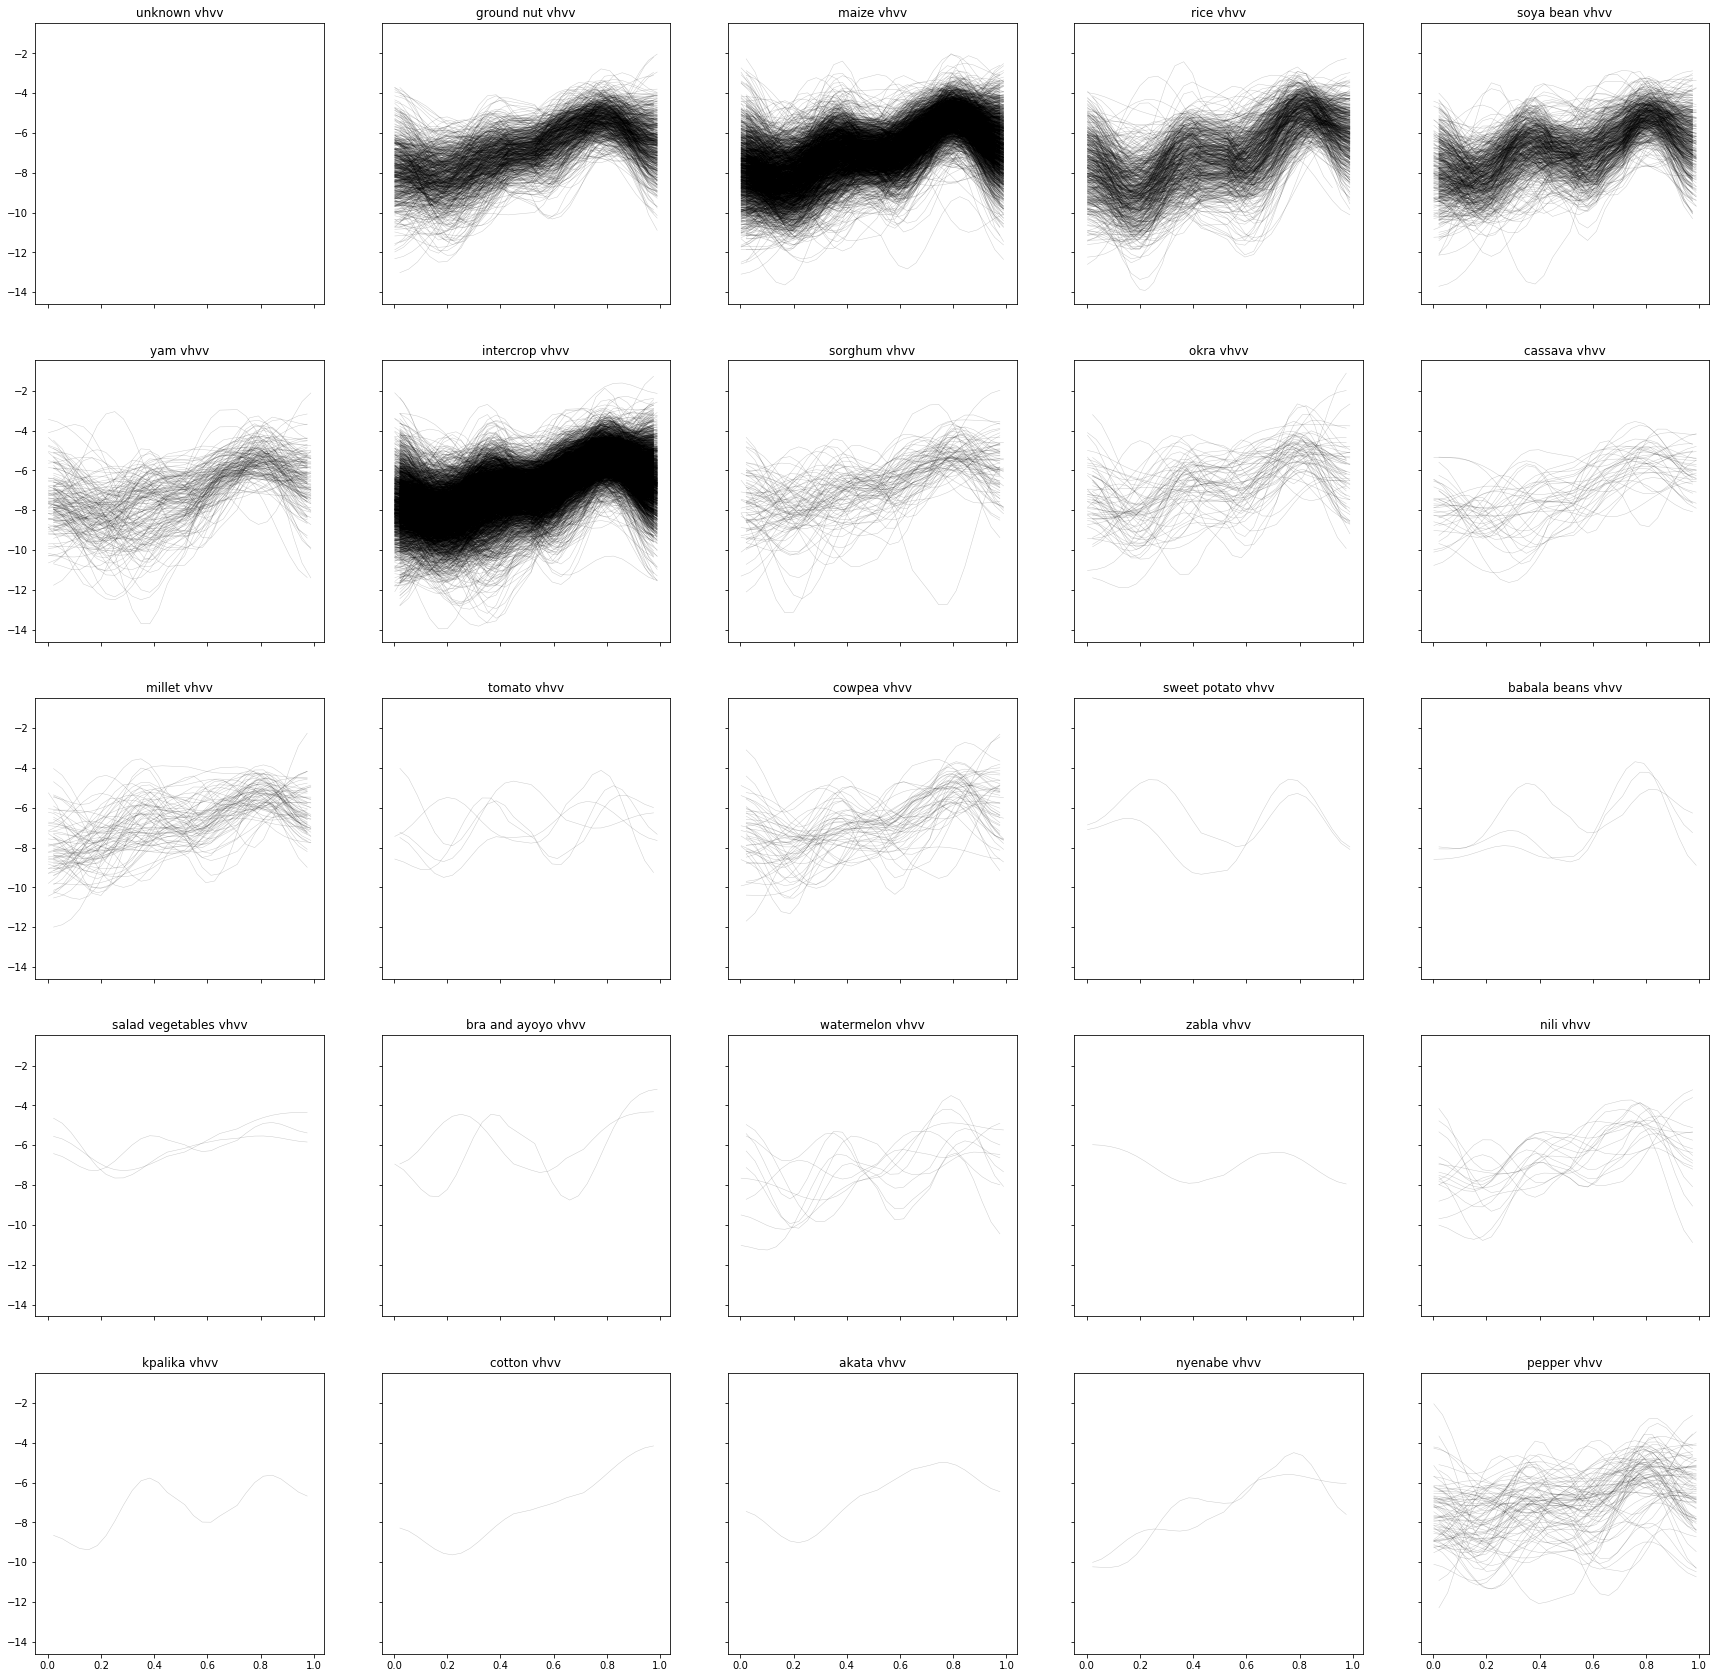

In [4]:
#####
erosioniterations = 2
index = s1indices.index("vhvv")
ncoeff = 6
#####

from compression import dct
from compression import idct
from compression import dct_fittingconditions

datapos = index + len(s1bands)

fig,ax = matplotlib.pyplot.subplots(5,5,figsize=[30,30],sharex="all",sharey="all")
axs = ax.ravel()
for i in range(len(groundmetadata)):
    tileid = groundmetadata[i]["id"].split("_")[len(groundmetadata[i]["id"].split("_"))-1]
    if tileid not in skiplist:
        tilehandle = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["groundcollection"]}/{datasetinfo["groundcollection"]}_{tileid}/{datasetinfo["groundname"]}')
        tiledata = numpy.array(tilehandle.GetRasterBand(1).ReadAsArray(),dtype="int")
        crops = numpy.unique(tiledata[tiledata != 0])
        fieldmasks = erodedfieldmasks(tiledata,erosioniterations)
        #
        s1items,s1dates = get_tileitems_from_collection(tileid,s1metadata,datasetinfo,verbose=0)
        s1data = load_satellite_data_as_array(s1items,s1bands,s1indices,datasetinfo,datasetinfo["s1shape"])
        #
        for j in range(len(fieldmasks)):
            for k in range(fieldmasks[j][1]):
                data = []
                dates = []
                for m in range(len(s1items)):
                    fm = numpy.copy(fieldmasks[j][0])
                    if len(s1data[m][datapos][fm == k+1]) > 0:
                        data.append(numpy.mean(s1data[m][datapos][fm == k+1]))
                        dates.append(s1dates[m])
                if len(data) > 0:
                    data = numpy.array(data)
                    dpos = numpy.array(datepositions(dates))                
                    if numpy.isnan(numpy.sum(data)) == False and numpy.min(data) > -15.0 and numpy.max(data) < 0.0:
                        if dct_fittingconditions(dpos,data,minduration=0.9,maxgap=0.33) == True:
                            dctcoeff = dct(data,len(data))
                            inverse = idct(dctcoeff,ncoeff)    
                            axs[crops[j]].plot(dpos,inverse,color="black",linewidth=0.5,alpha=0.2)
for i in range(len(groundlabels)):
    axs[i].set_title(f'{groundlabels[i]["crop"]} {s1indices[index]}')
matplotlib.pyplot.show()